# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP - redukcja wymiarowości

In [127]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki `artists.parquet` i `tracks.parquet` do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Dokonaj filtrowania:
   - pozostaw artystów z popularnością >= 55
   - pozostaw piosenki z popularnością >= 55
   - usuń piosenki trwające powyżej 600000 ms (10 minut)
   - użyj funkcji `remove_weird_genres()`, żeby usunąć artystów z ekstremalnie rzadkich gatunków muzycznych
   - użyj funkcji `filter_english_only()`, aby pozostawić tylko anglojęzyczne tytuły
6. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
7. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
8. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
9. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
10. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
```
11. Wypisz finalną liczbę piosenek (rozmiar zbioru).

**Uwaga:** jeżeli notebook będzie wykonywał się zbyt długo, to można ustawić wyższy próg popularności, żeby uzyskać mniejszy podzbiór najbardziej popularnych piosenek.

In [128]:

import ast
from fast_langdetect import detect as detect_language


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks


def remove_weird_genres(df_songs: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for song_genres in df_songs["genres"]:
        all_genres.extend(ast.literal_eval(song_genres))
    
    df_genres = pd.Series(all_genres).value_counts().reset_index()
    
    weird_genres = df_genres.loc[df_genres["count"] < 150, "index"]
    weird_genres = set(weird_genres.tolist())
    
    to_keep = []
    for song_genres in df_songs["genres"]:
        song_genres = set(ast.literal_eval(song_genres))
        not_all_weird = len(song_genres - weird_genres) > 0
        to_keep.append(not_all_weird)
    
    df_songs = df_songs[to_keep]
    return df_songs


def filter_english_only(df_songs: pd.DataFrame) -> pd.DataFrame:
    english = [
        detect_language(title[:100], low_memory=False)["lang"] == "en"
        for title in df_songs["name"]
    ]
    return df_songs[english]


In [129]:
df_artists = pd.read_csv("artists.csv")
df_tracks = pd.read_csv("tracks.csv")

df_artists = df_artists.dropna()
df_tracks = df_tracks.dropna()

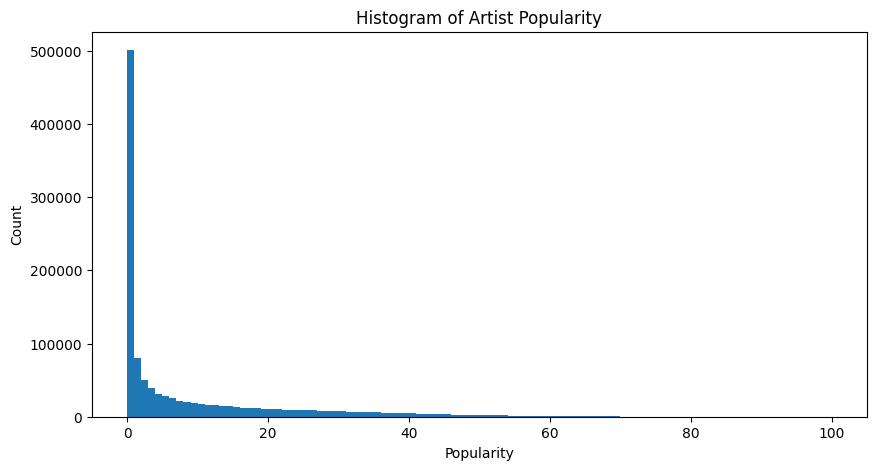

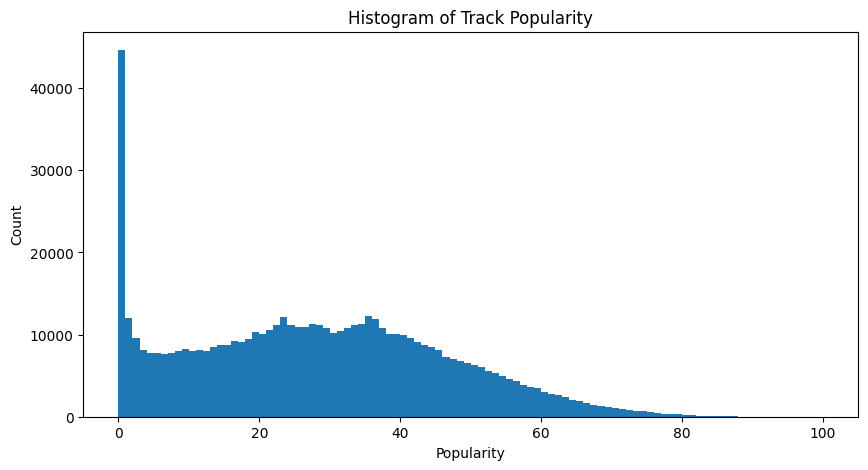

In [130]:
# Histogram of artist popularity
df_artists["popularity"].plot(
	kind="hist",
	bins=100,
	figsize=(10, 5)
)
plt.title("Histogram of Artist Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

# Histogram of track popularity
df_tracks["popularity"].plot(
	kind="hist",
	bins=100,
	figsize=(10, 5)
)
plt.title("Histogram of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()


In [131]:
df_artists = df_artists.loc[df_artists["popularity"] >= 55]
df_tracks = df_tracks.loc[(df_tracks["popularity"] >= 55) & (df_tracks["duration_ms"] <= 600000	)]

df_artists = remove_weird_genres(df_artists)
df_tracks = filter_english_only(df_tracks)

df_tracks = extract_artist_id(df_tracks)


In [132]:
df_songs = pd.merge(
    df_tracks,
	df_artists,
	left_on="main_artist_id",
	right_on="id",
	how="left",
    suffixes=["_track", "_artist"]
)


In [133]:
df_songs = df_songs.drop_duplicates(subset=["name_track", "name_artist"])

In [134]:
df_songs_info = df_songs[["name_track","name_artist","genres"]]
df_songs = df_songs.drop(columns=["name_track", "name_artist", "genres"])

In [135]:
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
df_songs_feature = df_songs[songs_features_cols].copy()

In [136]:
print(f"Number of songs: {df_songs.shape}")

Number of songs: (25456, 23)


Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadku PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [137]:
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df_songs_feature)

In [138]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap.umap_ import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # PCA
        self.pca = PCA(n_components=2, random_state=0)
        self.X_pca = self.pca.fit_transform(X)

        # UMAP
        self.umap = UMAP(n_components=2, random_state=0, low_memory=False)
        self.X_umap = self.umap.fit_transform(X)

        # Store original data
        self.X = X

        # Prepare figure
        # plt.style.use("seaborn-whitegrid")
        # plt.rcParams["figure.figsize"] = (9, 3)

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(self.X))

        fig, axes = plt.subplots(1, 2, figsize=(9, 3))

        # axes[0] - PCA, axes[1] - UMAP
        axes[0].scatter(np.asarray(self.X_pca)[:, 0], np.asarray(self.X_pca)[:, 1], c=labels, cmap="viridis", s=1)
        axes[0].set_title("PCA")
        axes[0].set_xlabel("PCA Component 1")
        axes[0].set_ylabel("PCA Component 2")
		
        axes[1].scatter(np.asarray(self.X_umap)[:, 0], np.asarray(self.X_umap)[:, 1], c=labels, cmap="viridis", s=1)
        axes[1].set_title("UMAP")
        axes[1].set_xlabel("UMAP Component 1")
        axes[1].set_ylabel("UMAP Component 2")

        fig.suptitle("Clustering visualization")
        plt.show()


c:\University_CS\Year III\Semester VI\basics-of-machine-learning\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\University_CS\Year III\Semester VI\basics-of-machine-learning\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



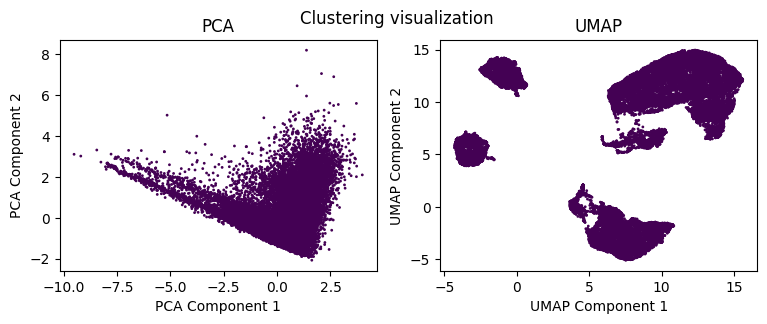

In [139]:
clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

// skomentuj tutaj

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [140]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres if pd.notnull(x)] # Nie wiem czemu ale tutaj miałem NaN wiec musiałem dodać if
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: DBSCAN) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(X_cluster, cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self,
        X: pd.DataFrame,
        cluster_songs_info: pd.DataFrame,
        cluster_probas: np.ndarray,
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

Number of clusters: 1


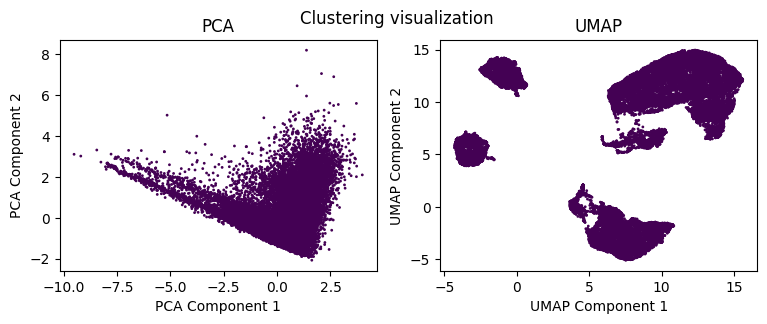

Cluster 0 size: 25456


,Track,Artist
0,Just A Lover,Hayden James
1,Rasta Courage,NaN
2,"Yes Sir, I Can Boogie",NaN
3,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
4,"Odhani (From ""Made in China"")",Sachin-Jigar
5,Drive (For Daddy Gene),Alan Jackson
6,Fake ID,Riton
7,Brown Skin,India.Arie
8,It's All About Me,Mýa
9,Sexy Lady,NaN


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'rap', 'pop rap', 'hip hop', 'classic rock', 'mellow gold', 'soft rock']


In [141]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


In [144]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import numpy as np

import matplotlib.pyplot as plt

kmeans_3 = KMeans(n_clusters=3, n_init="auto", random_state=0)
kmeans_3.fit(X)
labels_3 = kmeans_3.labels_

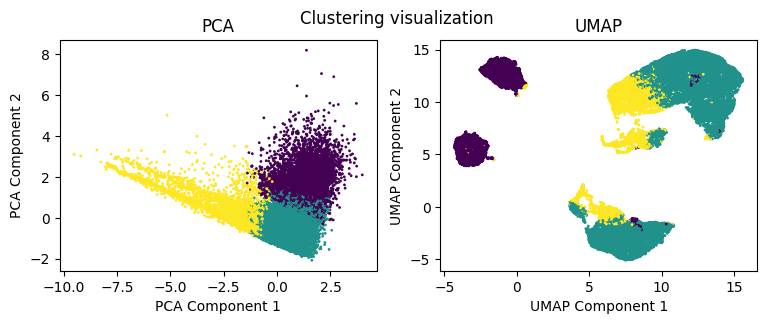

Number of clusters: 3
CH-index value: 4828.96


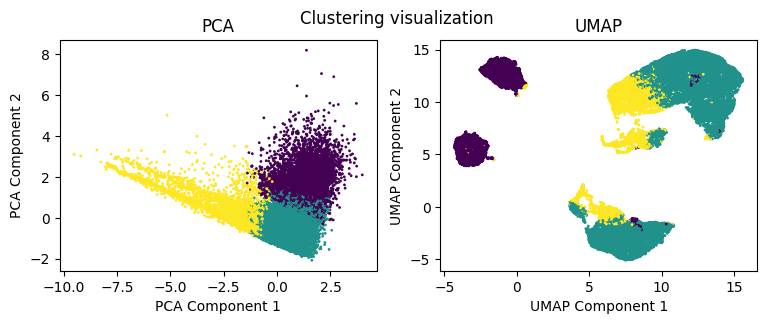

Cluster 0 size: 4999


,Track,Artist
0,Surfer,NaN
1,Soleil,Roméo Elvis
2,Made In Turkey,NaN
3,okay,LANY
4,Blood On My Jeans,NaN
5,Broken Clocks,SZA
6,BODY PARTS - I denti,NaN
7,Lost,Frank Ocean
8,Worst Behavior,Drake
9,Augenblick (feat. Summer Cem),KC Rebell


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'post-teen pop']
Cluster 1 size: 15308


,Track,Artist
0,Rather Be (feat. Jess Glynne),Clean Bandit
1,Fake ID,Riton
2,Keeping Your Head Up,Birdy
3,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
4,Sexy Lady,NaN
5,"Yes Sir, I Can Boogie",NaN
6,Lay It All on Me (feat. Ed Sheeran),Rudimental
7,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
8,Ishq Tera,Guru Randhawa
9,Gol,Cali Y El Dandee


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'modern rock', 'pop rock', 'soft rock', 'mellow gold', 'album rock']
Cluster 2 size: 5149


,Track,Artist
0,Bird Song,Elderbrook
1,All I've Ever Known,Bahamas
2,Stay Alive,José González
3,Don't Follow,Alice In Chains
4,Buzzcut Season,Lorde
5,Baby You're Worth It,NaN
6,Your Latest Trick,Dire Straits
7,Calm After The Storm,NaN
8,2009,NaN
9,Frozen,Madonna


Top 10 genres in the cluster: ['pop', 'rock', 'adult standards', 'mellow gold', 'classic rock', 'soft rock', 'post-teen pop', 'album rock', 'folk rock', 'dance pop']


In [145]:
clustering_visualizer.visualize(labels_3)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, kmeans_3)

In [146]:
ch_scores = []
cluster_range = range(5, 21)
kmeans_models = []
for k in cluster_range:
	model = KMeans(n_clusters=k, n_init="auto", random_state=0)
	model.fit(X)
	kmeans_models.append(model)
	ch = calinski_harabasz_score(X, model.labels_)
	ch_scores.append(ch)

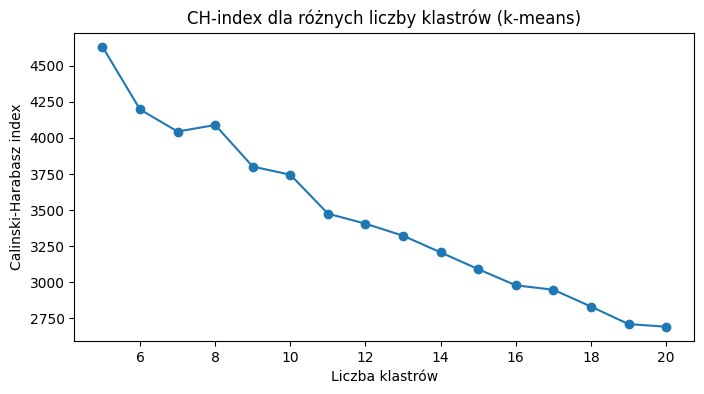

In [147]:
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, ch_scores, marker='o')
plt.xlabel("Liczba klastrów")
plt.ylabel("Calinski-Harabasz index")
plt.title("CH-index dla różnych liczby klastrów (k-means)")
plt.show()

Najlepszy model: 5 klastrów, CH-index = 4630.90


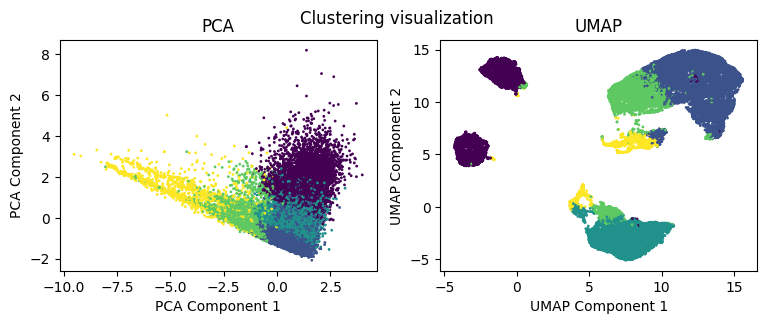

Number of clusters: 5
CH-index value: 4630.90


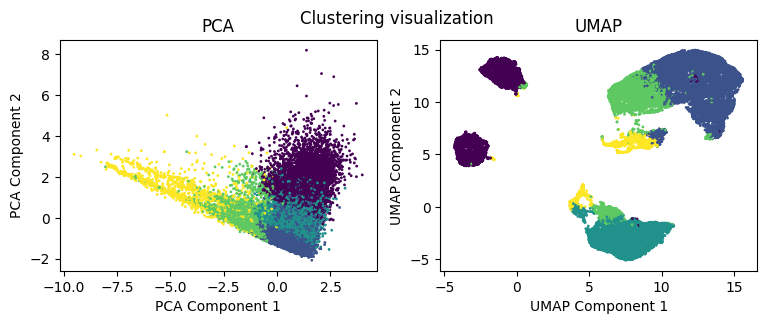

Cluster 0 size: 4782


,Track,Artist
0,Surfer,NaN
1,Made In Turkey,NaN
2,Soleil,Roméo Elvis
3,okay,LANY
4,Blood On My Jeans,NaN
5,Broken Clocks,SZA
6,BODY PARTS - I denti,NaN
7,Worst Behavior,Drake
8,Lost,Frank Ocean
9,Augenblick (feat. Summer Cem),KC Rebell


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'hardcore hip hop']
Cluster 1 size: 9190


,Track,Artist
0,Rather Be (feat. Jess Glynne),Clean Bandit
1,Keeping Your Head Up,Birdy
2,Fake ID,Riton
3,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
4,Lay It All on Me (feat. Ed Sheeran),Rudimental
5,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
6,"Yes Sir, I Can Boogie",NaN
7,Ishq Tera,Guru Randhawa
8,Sexy Lady,NaN
9,Gol,Cali Y El Dandee


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'pop rock', 'modern rock', 'soft rock', 'mellow gold', 'album rock']
Cluster 2 size: 5634


,Track,Artist
0,Give It Away,NaN
1,One Day / Reckoning Song (Wankelmut Remix) [Ra...,NaN
2,One Day / Reckoning Song (Wankelmut Remix) - R...,NaN
3,Secret Door,Arctic Monkeys
4,OK,Robin Schulz
5,Favours,Hayden James
6,Closer,Ne-Yo
7,React,The Pussycat Dolls
8,Black,NaN
9,Going Dumb (with Stray Kids),Alesso


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'edm', 'classic rock', 'tropical house', 'album rock']
Cluster 3 size: 4398


,Track,Artist
0,As Tears Go By - Mono Version,The Rolling Stones
1,Frozen,Madonna
2,(You Make Me Feel Like) A Natural Woman,Aretha Franklin
3,Hard Act To Follow,NaN
4,Chachachá,NaN
5,The Load-Out - 2018 Remaster,Jackson Browne
6,Tenerife Sea,Ed Sheeran
7,The Last Waltz,Engelbert Humperdinck
8,Only Love Can Break Your Heart,Neil Young
9,Linda Rosa,NaN


Top 10 genres in the cluster: ['pop', 'rock', 'adult standards', 'mellow gold', 'classic rock', 'soft rock', 'post-teen pop', 'folk rock', 'dance pop', 'pop rock']
Cluster 4 size: 1452


,Track,Artist
0,Anakin vs. Obi-Wan,NaN
1,Romantic Flight - From How To Train Your Drago...,NaN
2,Malin's Song,NaN
3,With Or Without You,NaN
4,I Exist I Exist I Exist,Flatsound
5,About Today,The National
6,Belle,NaN
7,Tender love,NaN
8,Cocaine,J.J. Cale
9,Losing Interest (feat. Lane 37),NaN


Top 10 genres in the cluster: ['rock', 'alternative rock', 'art rock', 'classic rock', 'permanent wave', 'album rock', 'alternative metal', 'indie rock', 'modern rock', 'tropical house']


In [148]:
best_k_idx = np.argmax(ch_scores)
best_k = cluster_range[best_k_idx]
best_model = kmeans_models[best_k_idx]
best_labels = best_model.labels_

print(f"Najlepszy model: {best_k} klastrów, CH-index = {ch_scores[best_k_idx]:.2f}")

clustering_visualizer.visualize(best_labels)

kmeans_analyzer.analyze_clustering(X, best_model)

// skomentuj tutaj

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 115
Percentage of noise points: 52.20%
CH-index value: 76.20


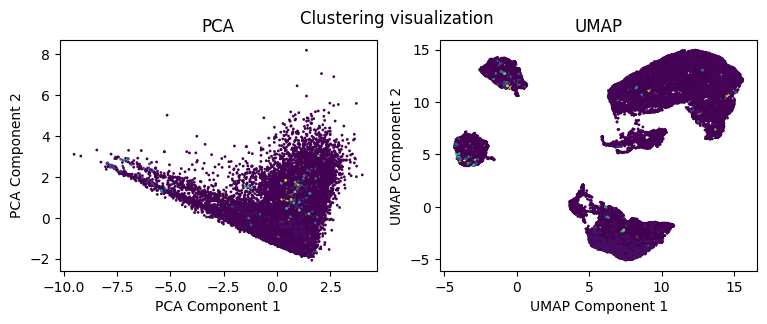

Cluster 0 size: 8166


,Track,Artist
0,I'd Rather,Luther Vandross
1,Penny Lane - Remastered 2009,The Beatles
2,Black,Dierks Bentley
3,Death On Two Legs (Dedicated To...) - Remaster...,Queen
4,Rotterdam (Or Anywhere),The Beautiful South
5,"Believe It or Not (Theme from ""Greatest Americ...",NaN
6,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
7,Drive (For Daddy Gene),Alan Jackson
8,You and I,Wilco
9,Apologize,OneRepublic


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'pop rock', 'classic rock', 'soft rock', 'mellow gold', 'modern rock', 'contemporary country']
Cluster 3 size: 2785


,Track,Artist
0,OK,Robin Schulz
1,React,The Pussycat Dolls
2,Foreplay,Jalen Santoy
3,Rivers,NaN
4,From Hell with Love,NaN
5,Going Dumb (with Stray Kids),Alesso
6,Somewhere With You,Kenny Chesney
7,Give It Away,NaN
8,Ocean Drive,Duke Dumont
9,Summer On You (feat. Wulf),Sam Feldt


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'edm', 'modern rock', 'tropical house', 'alternative metal', 'pop rock']
Cluster 22 size: 216


,Track,Artist
0,Dicked Down in Dallas,NaN
1,Take Care of You,Ella Henderson
2,Roses,Outkast
3,Freak,Doja Cat
4,Free,6LACK
5,Clic Clac Bang Bang,Jok'air
6,Goosebumps,Travis Scott
7,Fuck You Bitch,NaN
8,Menage A Trois,LIZOT
9,Some Nights,fun.


Top 10 genres in the cluster: ['rap', 'pop rap', 'pop', 'hip hop', 'dance pop', 'trap', 'southern hip hop', 'post-teen pop', 'gangster rap', 'electropop']
Cluster 2 size: 144


,Track,Artist
0,Uyiril Thodum,NaN
1,Childs Play (feat. Chance the Rapper),SZA
2,Hold Me While You Wait - Recorded at Spotify S...,Lewis Capaldi
3,Fever To The Form,Nick Mulvey
4,Babooshka,Kate Bush
5,(Getting Some) Fun out of Life,Madeleine Peyroux
6,Million Years Ago,Adele
7,There's Nothing Holdin Me Back,NaN
8,Blue Ridge Mountains,Fleet Foxes
9,'Round Midnight (feat. John Coltrane),NaN


Top 10 genres in the cluster: ['pop', 'desi pop', 'modern bollywood', 'dance pop', 'post-teen pop', 'filmi', 'r&b', 'rock', 'soul', 'electropop']


In [149]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

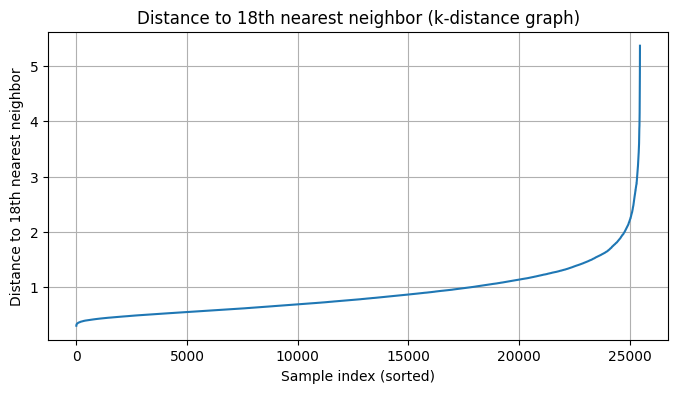

In [150]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 2 * X.shape[1]

nn = NearestNeighbors(n_neighbors=n_neighbors,n_jobs=-1)
nn.fit(X)
distances, _ = nn.kneighbors(X)

k_distances = distances[:, -1]
k_distances_sorted = np.sort(k_distances)

plt.figure(figsize=(8, 4))
plt.plot(k_distances_sorted)
plt.xlabel("Sample index (sorted)")
plt.ylabel(f"Distance to {n_neighbors}th nearest neighbor")
plt.title(f"Distance to {n_neighbors}th nearest neighbor (k-distance graph)")
plt.grid(True)
plt.show()

Punkt przegięcia moim zdaniem można tylko wyznaczyć na oko 

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 8
Percentage of noise points: 16.49%
CH-index value: 1938.13


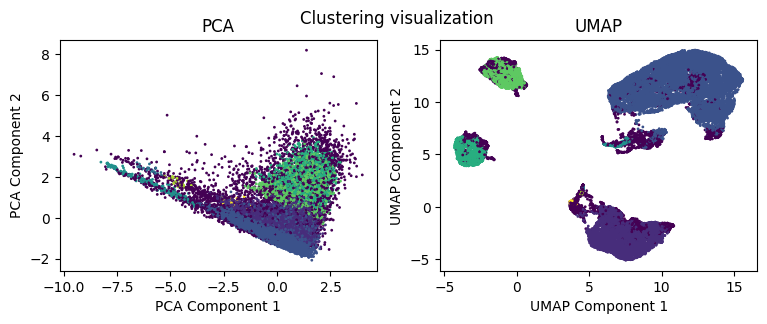

Cluster 1 size: 11928


,Track,Artist
0,Drive (For Daddy Gene),Alan Jackson
1,Rasta Courage,NaN
2,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
3,You and I,Wilco
4,"Odhani (From ""Made in China"")",Sachin-Jigar
5,Death On Two Legs (Dedicated To...) - Remaster...,Queen
6,Penny Lane - Remastered 2009,The Beatles
7,I'd Rather,Luther Vandross
8,Don't Leave Me This Way (feat. Teddy Pendergrass),Harold Melvin & The Blue Notes
9,Rotterdam (Or Anywhere),The Beautiful South


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'pop rock', 'soft rock', 'modern rock', 'album rock']
Cluster 0 size: 5499


,Track,Artist
0,One Day / Reckoning Song (Wankelmut Remix) [Ra...,NaN
1,One Day / Reckoning Song (Wankelmut Remix) - R...,NaN
2,The Sun,Parov Stelar
3,Rivers,NaN
4,Give It Away,NaN
5,Until The End Of Time (with Beyoncé),Justin Timberlake
6,OK,Robin Schulz
7,React,The Pussycat Dolls
8,Foreplay,Jalen Santoy
9,Going Dumb (with Stray Kids),Alesso


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'classic rock', 'edm', 'tropical house', 'album rock']
Cluster 5 size: 1894


,Track,Artist
0,Broken Clocks,SZA
1,just like magic,Ariana Grande
2,Worst Behavior,Drake
3,Gang,Mister V
4,Alien Boy,NaN
5,Augenblick (feat. Summer Cem),KC Rebell
6,Corrida,NaN
7,BODY PARTS - I denti,NaN
8,Lying Is the Most Fun a Girl Can Have Without ...,Panic! At The Disco
9,All Night (feat. Knox Fortune),Chance the Rapper


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'post-teen pop', 'east coast hip hop']
Cluster 4 size: 1622


,Track,Artist
0,Soleil,Roméo Elvis
1,A$AP Forever (feat. Moby),A$AP Rocky
2,Here I Am,Rick Ross
3,Shake That,Eminem
4,Phases,PRETTYMUCH
5,"Calipso (with Dardust) (feat. Sfera Ebbasta, M...",NaN
6,Ballin,Luciano
7,"A$AP Forever REMIX (feat. Moby, T.I. & Kid Cudi)",A$AP Rocky
8,Like That (feat. Gucci Mane),Doja Cat
9,In Love,NaN


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'r&b', 'east coast hip hop']
Cluster 3 size: 212


,Track,Artist
0,The Approaching Night,NaN
1,"Rhapsody On A Theme Of Paganini, Op.43: Variat...",NaN
2,Shivaratri,NaN
3,Georgia On My Mind,Oscar Peterson Trio
4,"Dawn - From ""Pride & Prejudice"" Soundtrack",NaN
5,528 Hz Release Inner Conflict & Struggle,NaN
6,Flight From The City,NaN
7,Mahler: Symphony No. 5 in C-Sharp Minor: IV. A...,NaN
8,Ice Dance,NaN
9,"Theme - From ""Emma""",NaN


Top 10 genres in the cluster: ['adult standards', 'rock', 'vocal jazz', 'bebop', 'cool jazz', 'jazz', 'art rock', 'album rock', 'classic rock', 'permanent wave']


In [152]:
from sklearn.cluster import DBSCAN

eps = 1.0 # Na oko
min_samples = 2 * X.shape[1]

clustering = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

Number of clusters: 10
Percentage of noise points: 2.91%
CH-index value: 1083.22


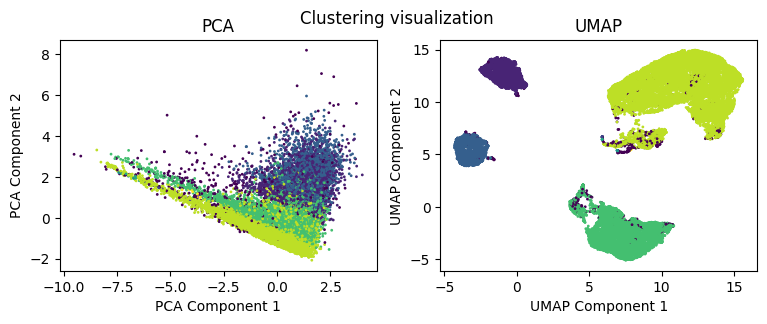

Cluster 8 size: 13307


,Track,Artist
0,7UP,Boy In Space
1,Freaks,Jordan Clarke
2,Fix It to Break It,Clinton Kane
3,Lotus Inn,Why Don't We
4,remember the mornings,Clinton Kane
5,Meet Again,KIMSEJEONG
6,Cross Road Blues,NaN
7,blind,ROLE MODEL
8,A Day At A Time,NaN
9,Mack the Knife,Louis Armstrong


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 6 size: 6626


,Track,Artist
0,The Sky Is A Neighborhood,Foo Fighters
1,Take Five,NaN
2,Beyond the Sea,Bobby Darin
3,Big Iron,NaN
4,Milestones (feat. John Coltrane & Cannonball A...,NaN
5,You Send Me - Mono,Sam Cooke
6,Jailhouse Rock,Elvis Presley
7,Autumn In New York,Ella Fitzgerald
8,What They'll Say About Us,FINNEAS
9,All of Me,Billie Holiday


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 0 size: 2562


,Track,Artist
0,Offside,NaN
1,NBP /,NaN
2,Take The Power Back,Rage Against The Machine
3,Bitches Ain't Shit,Dr. Dre
4,Bombtrack,Rage Against The Machine
5,Let Me Ride,Dr. Dre
6,Killing In The Name,Rage Against The Machine
7,Alwayz Into Somethin',N.W.A.
8,Unbelievable,NaN
9,Suck My Kiss,Red Hot Chili Peppers


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']
Cluster 2 size: 2176


,Track,Artist
0,The Streets - Re-Twist,NaN
1,My Block - Nitty Remix,2Pac
2,Addictive,NaN
3,I Wanna Be Somebody,W.A.S.P.
4,Wild Child,W.A.S.P.
5,Mother,Danzig
6,Fuck Tha Police,N.W.A.
7,Am I Demon,Danzig
8,Freddy K,NaN
9,Trendsetter,NaN


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']


In [153]:
clustering = HDBSCAN()
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?


min_cluster_size=30, min_samples=10
Number of clusters: 7
Percentage of noise points: 14.55%
CH-index value: 2490.92


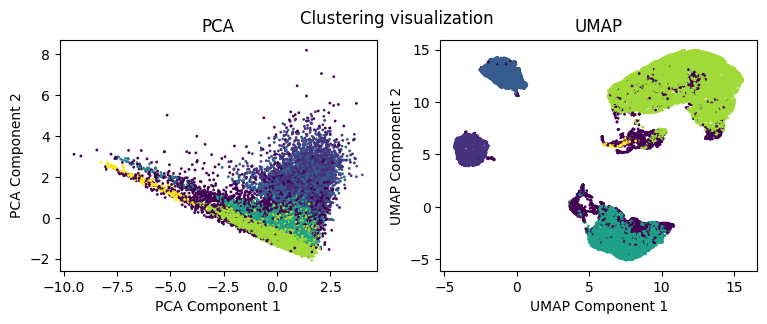

Cluster 5 size: 11700


,Track,Artist
0,Crazy For You,Adele
1,I Want You to Want Me,NaN
2,I Don't Believe You,P!nk
3,Without You,Hinder
4,Give Me Faith,NaN
5,Strong Enough,NaN
6,You And I,LÉON
7,Evacuate The Dancefloor,Cascada
8,Love Faces,Trey Songz
9,I Gotta Feeling - Edit,Black Eyed Peas


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'pop rock', 'mellow gold', 'soft rock', 'modern rock', 'album rock']
Cluster 3 size: 5001


,Track,Artist
0,Light My Fire,The Doors
1,Sunny Afternoon - Mono Mix,The Kinks
2,Fading Like A Flower,NaN
3,Fingers Crossed,Agnes
4,Heart Upon My Sleeve (feat. Imagine Dragons),Avicii
5,Safe Place,NaN
6,This Is the One,NaN
7,Friend Of Mine (feat. Vargas & Lagola),Avicii
8,Help! - Remastered 2009,The Beatles
9,I'm Happy Just To Dance With You - Remastered ...,The Beatles


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'edm', 'tropical house', 'classic rock', 'alternative metal']
Cluster 1 size: 2536


,Track,Artist
0,"Go Hard, Go Home (feat. Giz, Swellz & Choppa)",NaN
1,Drama,NaN
2,Are We the Waiting / St. Jimmy,NaN
3,"Work Hard, Play Hard",Wiz Khalifa
4,Some Nights,fun.
5,Banana Brain,NaN
6,Party On Fifth Ave.,Mac Miller
7,It's On,Eazy-E
8,Make Believe,NaN
9,WITHOUT YOU,NaN


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']
Cluster 0 size: 2173


,Track,Artist
0,Blow Your Mind (Mwah),Dua Lipa
1,Party on the West Coast (feat. Snoop Dogg),Matoma
2,Sham Pain,Five Finger Death Punch
3,Cool for the Summer,Demi Lovato
4,Good Weed Bad B*tch,K CAMP
5,Smile,Avril Lavigne
6,Am I Wrong (feat. ScHoolboy Q),NaN
7,Russian Roulette,Rihanna
8,Into It,Chase Atlantic
9,Bloodfeather,Highly Suspect


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']
Cluster 6 size: 218


,Track,Artist
0,Soft Piano,NaN
1,Appreciation,NaN
2,Flight From The City,NaN
3,Sleep Meditation,NaN
4,Sand Castles,NaN
5,"Rhapsody On A Theme Of Paganini, Op.43: Variat...",NaN
6,"Consolation No. 3 in D-Flat Major, S. 172",NaN
7,"Lyric Pieces, Book 5, Op. 54: Nocturne",NaN
8,Forget,NaN
9,Canon in D,NaN


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'rock', 'bebop', 'cool jazz', 'jazz', 'indie pop', 'indie folk', 'art rock', 'jazz fusion']

min_cluster_size=50, min_samples=10
Number of clusters: 6
Percentage of noise points: 12.20%
CH-index value: 2913.37


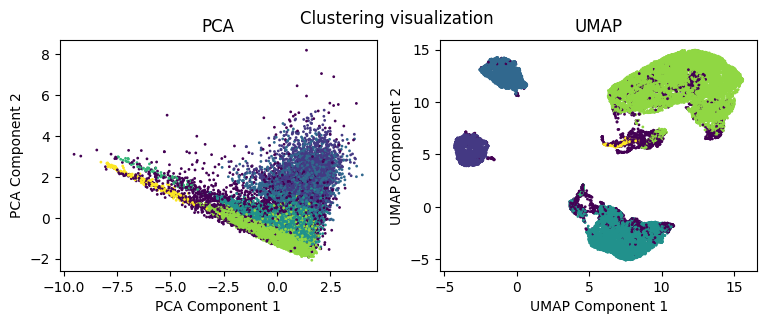

Cluster 4 size: 11700


,Track,Artist
0,Crazy For You,Adele
1,I Want You to Want Me,NaN
2,I Don't Believe You,P!nk
3,Without You,Hinder
4,Give Me Faith,NaN
5,Strong Enough,NaN
6,You And I,LÉON
7,Evacuate The Dancefloor,Cascada
8,Love Faces,Trey Songz
9,I Gotta Feeling - Edit,Black Eyed Peas


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'pop rock', 'mellow gold', 'soft rock', 'modern rock', 'album rock']
Cluster 2 size: 5638


,Track,Artist
0,Catamaran,Allah-Las
1,Partner In Crime,NaN
2,Heavy Hearted,NaN
3,Amaranth,NaN
4,Beggin - Original Version,Madcon
5,Middle Of The Night,The Vamps
6,10 Years,NaN
7,BlimE! - Ser Deg,NaN
8,Love Like This,Broiler
9,Two Black Cadillacs,Carrie Underwood


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'modern rock', 'edm', 'classic rock', 'tropical house', 'album rock']
Cluster 1 size: 2536


,Track,Artist
0,"Go Hard, Go Home (feat. Giz, Swellz & Choppa)",NaN
1,Drama,NaN
2,Are We the Waiting / St. Jimmy,NaN
3,"Work Hard, Play Hard",Wiz Khalifa
4,Some Nights,fun.
5,Banana Brain,NaN
6,Party On Fifth Ave.,Mac Miller
7,It's On,Eazy-E
8,Make Believe,NaN
9,WITHOUT YOU,NaN


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']
Cluster 0 size: 2173


,Track,Artist
0,Party on the West Coast (feat. Snoop Dogg),Matoma
1,Am I Wrong (feat. ScHoolboy Q),NaN
2,Sham Pain,Five Finger Death Punch
3,Cocoon,Catfish and the Bottlemen
4,Cool for the Summer,Demi Lovato
5,Smile,Avril Lavigne
6,Good Weed Bad B*tch,K CAMP
7,Club My - KMN Street EP.2,Miami Yacine
8,Ayye,Mac Miller
9,Bloodfeather,Highly Suspect


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']
Cluster 5 size: 218


,Track,Artist
0,Soft Piano,NaN
1,Appreciation,NaN
2,Flight From The City,NaN
3,Sleep Meditation,NaN
4,Sand Castles,NaN
5,"Rhapsody On A Theme Of Paganini, Op.43: Variat...",NaN
6,"Consolation No. 3 in D-Flat Major, S. 172",NaN
7,"Lyric Pieces, Book 5, Op. 54: Nocturne",NaN
8,Forget,NaN
9,Canon in D,NaN


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'rock', 'bebop', 'cool jazz', 'jazz', 'indie pop', 'indie folk', 'art rock', 'jazz fusion']

min_cluster_size=100, min_samples=10
Number of clusters: 5
Percentage of noise points: 8.05%
CH-index value: 3132.79


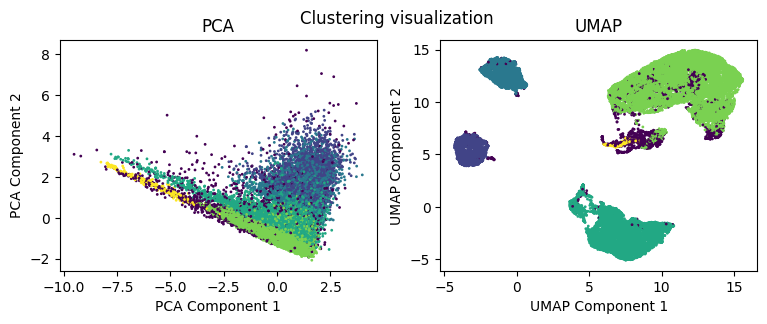

Cluster 3 size: 11700


,Track,Artist
0,Crazy For You,Adele
1,I Want You to Want Me,NaN
2,I Don't Believe You,P!nk
3,Without You,Hinder
4,Give Me Faith,NaN
5,Strong Enough,NaN
6,You And I,LÉON
7,Evacuate The Dancefloor,Cascada
8,Love Faces,Trey Songz
9,I Gotta Feeling - Edit,Black Eyed Peas


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'pop rock', 'mellow gold', 'soft rock', 'modern rock', 'album rock']
Cluster 2 size: 6780


,Track,Artist
0,WHISTLE - Japanese Version,BLACKPINK
1,Like a Stone,Audioslave
2,Scream Drive Faster,LAUREL
3,Sending Me Ur Loving,NaN
4,Come As You Are,Nirvana
5,Ridin High,NaN
6,Something,NaN
7,Love Bites - Remastered 2017,Def Leppard
8,Feel the Way I Do,NaN
9,The Riddle Anthem Rework,Mike Candys


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 1 size: 2536


,Track,Artist
0,White Wine,NaN
1,Black Beatles,Rae Sremmurd
2,Little Lion Man,NaN
3,Katy On a Mission,Katy B
4,Boasty (feat. Idris Elba),Wiley
5,Smog,Damso
6,Really Really,Kevin Gates
7,All Night Longer,Sammy Adams
8,All Time Low,Jon Bellion
9,Domination,Pantera


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']
Cluster 0 size: 2173


,Track,Artist
0,When We Were Kids,NaN
1,Butta Love,Next
2,Dubai Shit,Huncho Jack
3,Club My - KMN Street EP.2,Miami Yacine
4,Christian Dior,Jhay Cortez
5,The Hills,The Weeknd
6,90210 (feat. Kacy Hill),Travis Scott
7,Ayye,Mac Miller
8,do u even miss me at all?,gianni & kyle
9,The Break Up,Machine Gun Kelly


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']
Cluster 4 size: 218


,Track,Artist
0,Forget,NaN
1,Stillness Speaks,NaN
2,"Lyric Pieces, Book 5, Op. 54: Nocturne",NaN
3,"Piano Concerto No.20 in D minor, K.466: 2. Rom...",NaN
4,"Piano Concerto No.27 in B flat, K.595: 2. Larg...",NaN
5,"Consolation No. 3 in D-Flat Major, S. 172",NaN
6,"2 Pieces, Op. posth., B. 188: No. 1. Lullaby i...",NaN
7,"Salut d'Amour, Op. 12",NaN
8,Canon in D,NaN
9,Soothing Dog Music,NaN


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'rock', 'bebop', 'cool jazz', 'jazz', 'indie pop', 'indie folk', 'art rock', 'jazz fusion']

min_cluster_size=200, min_samples=10
Number of clusters: 5
Percentage of noise points: 8.05%
CH-index value: 3132.79


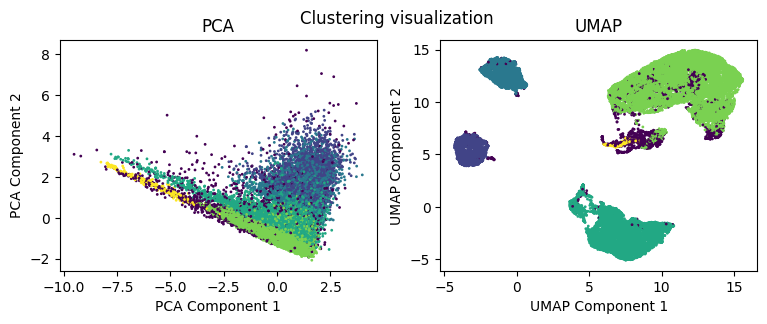

Cluster 3 size: 11700


,Track,Artist
0,Crazy For You,Adele
1,I Want You to Want Me,NaN
2,I Don't Believe You,P!nk
3,Without You,Hinder
4,Give Me Faith,NaN
5,Strong Enough,NaN
6,You And I,LÉON
7,Evacuate The Dancefloor,Cascada
8,Love Faces,Trey Songz
9,I Gotta Feeling - Edit,Black Eyed Peas


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'pop rock', 'mellow gold', 'soft rock', 'modern rock', 'album rock']
Cluster 2 size: 6780


,Track,Artist
0,Ridin High,NaN
1,Sending Me Ur Loving,NaN
2,Scream Drive Faster,LAUREL
3,Gimme! Gimme! Gimme! - Sgt Slick's Melbourne R...,NaN
4,Skyline,Möwe
5,Lemon Tree,Alle Farben
6,Feel the Way I Do,NaN
7,Let You Know,Flume
8,The Riddle Anthem Rework,Mike Candys
9,You Make Me Feel Like Dancing,Leo Sayer


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 1 size: 2536


,Track,Artist
0,Hangover,Taio Cruz
1,EVERE$T,NaN
2,Smog,Damso
3,Aluminium,NaN
4,Battle Royale feat. Panther - VIP Mix,NaN
5,Really Really,Kevin Gates
6,All Night Longer,Sammy Adams
7,All Time Low,Jon Bellion
8,Domination,Pantera
9,Make Believe,NaN


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']
Cluster 0 size: 2173


,Track,Artist
0,Drunk in Love (feat. Jay-Z),Beyoncé
1,Bella,UZI
2,All Mine,NaN
3,Bring It Back,Travis Porter
4,I THINK,"Tyler, The Creator"
5,Trap House (feat. Shoreline Mafia),03 Greedo
6,Just Friends,Hayden James
7,"Ain't It Different (feat. AJ Tracey, Stormzy &...",NaN
8,The World Is Yours,Nas
9,The Break Up,Machine Gun Kelly


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']
Cluster 4 size: 218


,Track,Artist
0,At Dawn,NaN
1,The Journey,NaN
2,Will you be there when I wake up,NaN
3,Sleepy Journey,NaN
4,Continuation,NaN
5,Canon in D,NaN
6,Hush Little Baby (Instrumental Version),NaN
7,Katawaredoki,NaN
8,"Canon in D Major, P.37",NaN
9,Soothing Dog Music,NaN


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'rock', 'bebop', 'cool jazz', 'jazz', 'indie pop', 'indie folk', 'art rock', 'jazz fusion']

min_cluster_size=4000, min_samples=10
Number of clusters: 3
Percentage of noise points: 1.25%
CH-index value: 4030.13


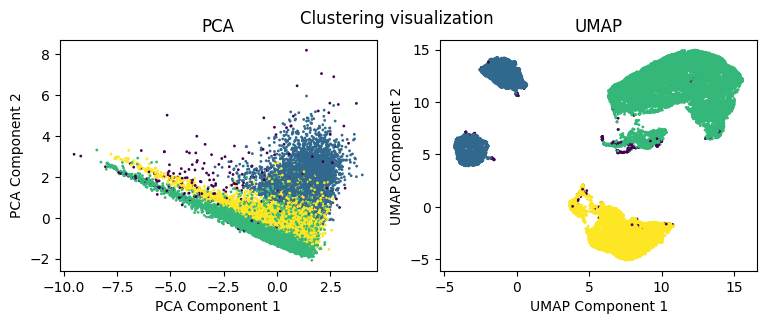

Cluster 1 size: 13587


,Track,Artist
0,Sex on Fire,Kings of Leon
1,Arms Tonite,NaN
2,Womanizer,Britney Spears
3,Poker Face,Lady Gaga
4,Love Story,Taylor Swift
5,Mayonaka no Door / Stay With Me,NaN
6,You're Gonna Miss This,Trace Adkins
7,Heartbeat,Scouting For Girls
8,7UP,Boy In Space
9,Meet Again,KIMSEJEONG


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'classic rock', 'post-teen pop', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 2 size: 6780


,Track,Artist
0,Milestones (feat. John Coltrane & Cannonball A...,NaN
1,You Send Me - Mono,Sam Cooke
2,Fingerprints,NaN
3,Rich,NaN
4,Bazaar - Official Sunburn Goa 2015 Anthem,KSHMR
5,Start A Riot,BANNERS
6,I'm Glad There Is You,Julie London
7,Talk,Why Don't We
8,I'm In The Mood For Love,Julie London
9,"Perhaps, Perhaps, Perhaps",Doris Day


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 0 size: 4772


,Track,Artist
0,Always Look On The Bright Side Of Life,NaN
1,You,NaN
2,Am I Demon,Danzig
3,Eazy-Duz-It,Eazy-E
4,South Of Heaven,Slayer
5,Children's Story,Slick Rick
6,General,NaN
7,Mitt Notre Dame,NaN
8,Trendsetter,NaN
9,Working Class Hero - Remastered 2010,John Lennon


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']


In [154]:
min_samples = 10
min_cluster_sizes = [30, 50, 100, 200,4000]

for min_cluster_size in min_cluster_sizes:
	clustering = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
	clustering.fit(X)
	print(f"\nmin_cluster_size={min_cluster_size}, min_samples={min_samples}")
	dbscan_analyzer.analyze_clustering(X, clustering)

Jak mam być szczerym to ilośc NaNów, moim zdaniem dyskwalifkuje tą implementacje, nie jestem natomiast w stanie znaleźć w niej błędu

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?